Subset of the dataset before preprocessing:


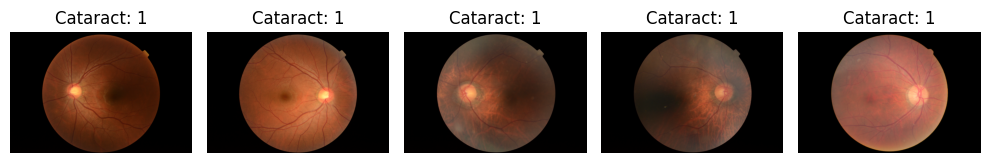


Subset of the dataset after preprocessing:


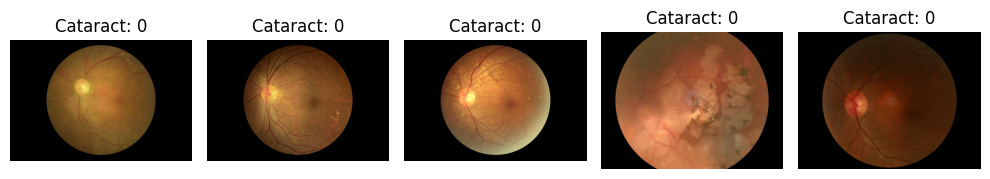


The count of df : 626
Column names in the DataFrame:
Index(['paths', 'cataract'], dtype='object')
Labels after conversion: [0 1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

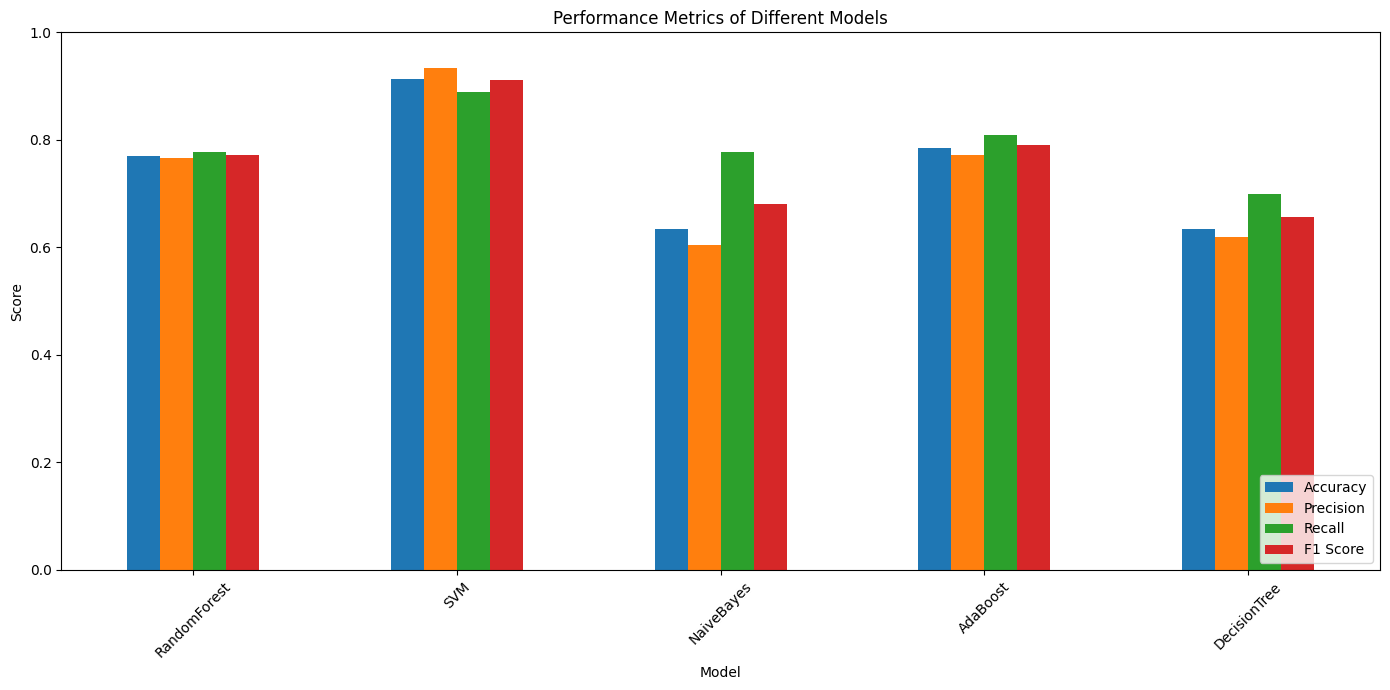

Top classifier: SVM


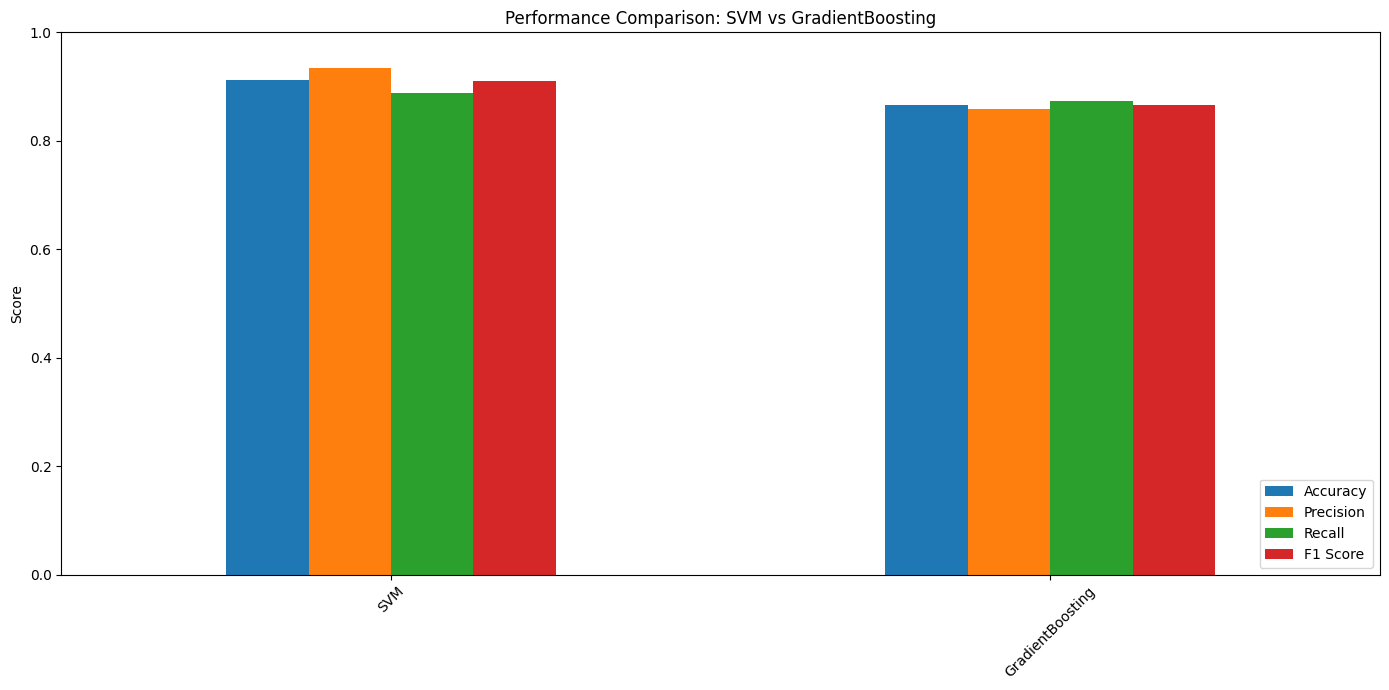

In [1]:
import numpy as np
import pandas as pd
import glob
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import efficientnet.tfkeras as efn
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.feature.texture import graycomatrix, graycoprops
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Constants
IMG_HEIGHT = 224
IMG_WIDTH = 224
SEED = 42

def load_and_preprocess_dataset():
    IMG_ROOT = 'C:/cataract/cataract2/dataset/'
    IMG_DIR = [IMG_ROOT+'1_normal', IMG_ROOT+'2_cataract']

    cat_df = pd.DataFrame(columns=['paths', 'cataract'])

    filepaths = glob.glob(IMG_ROOT + '*/*')
    for filepath in filepaths:
        filepath = os.path.split(filepath)
        path = filepath[0] + '/' + filepath[1]
        label = 0 if filepath[0] == IMG_DIR[0] else 1
        cat_df = pd.concat([cat_df, pd.DataFrame({'paths': [path], 'cataract': [label]})], ignore_index=True)

    cat_df = cat_df.query('0 <= cataract < 2')

    # Display a subset of the dataset before preprocessing
    display_subset_before_preprocessing(cat_df)

    # Perform data preprocessing
    ocu_df = preprocess_ocular_data()
    df = pd.concat([cat_df, ocu_df], ignore_index=True)

    # Balance the dataset
    df = balance_dataset(df)

    # Display a subset of the dataset after preprocessing
    display_subset_after_preprocessing(df)

    return df


# Preprocess ocular disease data
def preprocess_ocular_data():
    OCU_IMG_ROOT = 'C:/cataract/cataract1/ODIR-5K/ODIR-5K/Training Images/'
    ocu_df = pd.read_excel('C:/cataract/cataract1/ODIR-5K/ODIR-5K/data.xlsx')

    def has_cataract_mentioned(text):
        return 1 if 'cataract' in text else 0

    ocu_df['left_eye_cataract'] = ocu_df['Left-Diagnostic Keywords'].apply(has_cataract_mentioned)
    ocu_df['right_eye_cataract'] = ocu_df['Right-Diagnostic Keywords'].apply(has_cataract_mentioned)

    le_df = ocu_df.loc[:, ['Left-Fundus', 'left_eye_cataract']].rename(columns={'left_eye_cataract': 'cataract'})
    le_df['paths'] = OCU_IMG_ROOT + le_df['Left-Fundus']
    le_df = le_df.drop('Left-Fundus', axis=1)

    re_df = ocu_df.loc[:, ['Right-Fundus', 'right_eye_cataract']].rename(columns={'right_eye_cataract': 'cataract'})
    re_df['paths'] = OCU_IMG_ROOT + re_df['Right-Fundus']
    re_df = re_df.drop('Right-Fundus', axis=1)

    def downsample(df):
        df_positive = df.query('cataract==1')
        df_negative = df.query('cataract==0').sample(len(df_positive), random_state=SEED)
        return pd.concat([df_positive, df_negative])

    le_df = downsample(le_df)
    re_df = downsample(re_df)

    ocu_df = pd.concat([le_df, re_df])
    return ocu_df

def display_image_subset(df, subset_size=5):
    plt.figure(figsize=(10, 5))
    for i in range(subset_size):
        plt.subplot(1, subset_size, i+1)
        img = cv2.imread(df.iloc[i]['paths'])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.title(f"Cataract: {df.iloc[i]['cataract']}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Display a subset of the dataset before preprocessing
def display_subset_before_preprocessing(df, subset_size=5):
    print("Subset of the dataset before preprocessing:")
    display_image_subset(df, subset_size)
    print()

# Display a subset of the dataset after preprocessing
def display_subset_after_preprocessing(df, subset_size=5):
    print("Subset of the dataset after preprocessing:")
    display_image_subset(df, subset_size)
    print()

# Display a subset of the training data
def display_subset_training_data(train_df, subset_size=5):
    print("Subset of the training data:")
    display_image_subset(train_df, subset_size)
    print()

def balance_dataset(df):
    cat_1_count = sum(df['cataract'])
    cat_0_count = len(df) - cat_1_count
    if cat_0_count > cat_1_count:
        df = pd.concat([df.query('cataract==1'), df.query('cataract==0').sample(cat_1_count, random_state=SEED)])
    elif cat_1_count > cat_0_count:
        df = pd.concat([df.query('cataract==0'), df.query('cataract==1').sample(cat_0_count, random_state=SEED)])
    return df


def denoise_image(img):
    return cv2.medianBlur(img, 5)

def enhance_contrast(img):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    lab_planes = list(cv2.split(lab))
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    lab_planes[0] = clahe.apply(lab_planes[0])
    lab = cv2.merge(lab_planes)
    return cv2.cvtColor(lab, cv2.COLOR_Lab2RGB)

def equalize_histogram(img):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    lab_planes = list(cv2.split(lab))
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    lab_planes[0] = clahe.apply(lab_planes[0])
    lab = cv2.merge(lab_planes)
    return cv2.cvtColor(lab, cv2.COLOR_Lab2RGB)

def apply_median_filter(img):
    return cv2.medianBlur(img, 5)

def normalize_image(img):
    return img / 255.0

def augment_image(img):
    # Data augmentation techniques
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
    img = img.reshape((1,) + img.shape)
    for batch in datagen.flow(img, batch_size=1):
        return batch[0]
    return img

def extract_glcm_features(image, distances=[1], angles=[0], levels=256, symmetric=True, normed=True):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Convert to unsigned integer type if not already
    if gray_image.dtype != np.uint8:
        gray_image = np.uint8(gray_image)
    
    glcm = graycomatrix(gray_image,
                        distances=distances,
                        angles=angles,
                        levels=levels,
                        symmetric=symmetric,
                        normed=normed)
    features = []
    features.append(graycoprops(glcm, 'contrast').flatten())
    features.append(graycoprops(glcm, 'dissimilarity').flatten())
    features.append(graycoprops(glcm, 'homogeneity').flatten())
    features.append(graycoprops(glcm, 'energy').flatten())
    features.append(graycoprops(glcm, 'correlation').flatten())
    return np.concatenate(features)

def extract_features(df):
    base_model = efn.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    model = Sequential([base_model, GlobalAveragePooling2D()])
    features = []
    texture_features_subset = []
    for i, path in enumerate(df['paths']):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Preprocessing Steps
        img = denoise_image(img)
        img = enhance_contrast(img)
        img = equalize_histogram(img)  # Histogram Equalization
        img = apply_median_filter(img)  # Median Filtering
        img = augment_image(img)  # Optional: Data Augmentation
        img = normalize_image(img)

        # Resize the image for EfficientNet
        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
        img = np.expand_dims(img, axis=0)
        feature_vector = model.predict(img)
        feature_vector = feature_vector.flatten()

        # Extract GLCM features and concatenate them
        glcm_features = extract_glcm_features(cv2.imread(path))
        combined_features = np.concatenate((feature_vector, glcm_features))

        features.append(combined_features)

        if i < 5:  # Store a subset of the texture features
            texture_features_subset.append(glcm_features)
    print("Subset of extracted GLCM texture features:")
    print(np.array(texture_features_subset))
    return np.array(features)

def main():
    df = load_and_preprocess_dataset()
    
    print(f'The count of df : {len(df)}')

    print("Column names in the DataFrame:")
    print(df.columns)

    target_column = 'cataract'

    if target_column not in df.columns:
        raise ValueError(f"Column '{target_column}' not found in the DataFrame. Available columns: {df.columns}")

    y = df[target_column].values
    y = y.astype(int)
    print(f"Labels after conversion: {np.unique(y)}")

    X = extract_features(df)

    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Apply PCA
    pca = PCA(n_components=0.95)
    X_pca = pca.fit_transform(X_scaled)

    # Split the dataset
    X_train, X_valid, y_train, y_valid = train_test_split(X_pca, y, test_size=0.2, random_state=SEED, stratify=y)

    y_train = y_train.astype(int)
    y_valid = y_valid.astype(int)
    print(f"Training labels: {np.unique(y_train)}")
    print(f"Validation labels: {np.unique(y_valid)}")

    # Define models except GradientBoosting
    models = {
        "RandomForest": RandomForestClassifier(random_state=SEED),
        "SVM": SVC(random_state=SEED),
        "NaiveBayes": GaussianNB(),
        "AdaBoost": AdaBoostClassifier(random_state=SEED),
        "DecisionTree": DecisionTreeClassifier(random_state=SEED)
    }

    results = []

    for name, model in models.items():
        print(f"Training {name}...")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_valid)

        accuracy = accuracy_score(y_valid, y_pred)
        precision = precision_score(y_valid, y_pred)
        recall = recall_score(y_valid, y_pred)
        f1 = f1_score(y_valid, y_pred)

        print(f"{name} - Accuracy: {accuracy:.4f}")
        print(f"{name} - Precision: {precision:.4f}")
        print(f"{name} - Recall: {recall:.4f}")
        print(f"{name} - F1 Score: {f1:.4f}")
        print()

        results.append((name, accuracy, precision, recall, f1))

    # Convert results to DataFrame
    metrics_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score"])
    metrics_df.set_index("Model", inplace=True)

    # Plot the performance of all models except GradientBoosting
    metrics_df.plot(kind='bar', figsize=(14, 7))
    plt.title("Performance Metrics of Different Models")
    plt.ylabel("Score")
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

    # Identify the top classifier
    top_model_name = metrics_df['Accuracy'].idxmax()
    print(f"Top classifier: {top_model_name}")

    # Compare the top classifier with GradientBoosting
    top_model = models[top_model_name]
    gradient_boosting = GradientBoostingClassifier(random_state=SEED)

    top_model.fit(X_train, y_train)
    y_pred_top = top_model.predict(X_valid)
    y_pred_gb = gradient_boosting.fit(X_train, y_train).predict(X_valid)

    top_model_metrics = [
        accuracy_score(y_valid, y_pred_top),
        precision_score(y_valid, y_pred_top),
        recall_score(y_valid, y_pred_top),
        f1_score(y_valid, y_pred_top)
    ]

    gb_metrics = [
        accuracy_score(y_valid, y_pred_gb),
        precision_score(y_valid, y_pred_gb),
        recall_score(y_valid, y_pred_gb),
        f1_score(y_valid, y_pred_gb)
    ]

    comparison_df = pd.DataFrame(
        [top_model_metrics, gb_metrics],
        columns=["Accuracy", "Precision", "Recall", "F1 Score"],
        index=[top_model_name, "GradientBoosting"]
    )

    # Plot the comparison
    comparison_df.plot(kind='bar', figsize=(14, 7))
    plt.title(f"Performance Comparison: {top_model_name} vs GradientBoosting")
    plt.ylabel("Score")
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()
